In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
# Load the Excel file into a DataFrame
df = pd.read_excel('Filtered_sandbox_errors.xlsx')

# Function to get first two lines from the 'Error' column
def get_first_few_lines(text):
    # Split the text by line breaks and return the first two lines
    lines = text.split('\\\\n')
    return '\n'.join(lines[:2])

#print(f"First three lines of the first row: {get_first_few_lines(df['Error'][0])}")

# Apply the function to the 'Error' column
df['Error'] = df['Error'].apply(get_first_few_lines)

# Save the modified DataFrame back to Excel
df.to_excel('modified_file_1.xlsx', index=False)



In [ ]:
# label_encoder = LabelEncoder()
# df['module_type_encoded'] = label_encoder.fit_transform(df['module type'])

tfid_vectorizer = TfidfVectorizer()

kmeans = KMeans(n_clusters=5, random_state=42)

pipeline = Pipeline(steps=[
    ('features', ColumnTransformer(
        transformers=[
            # ('account_id', 'passthrough', ['account id']),  # Leave the 'account id' as is
            # ('module_type', 'passthrough', ['module_type_encoded']),  # Leave the encoded 'module_type' as is
            ('error', tfid_vectorizer, 'Error')  # Transform 'Error' column using TF-IDF
        ])),
    ('scaler', StandardScaler(with_mean=False)),  # Optional: Scale the features to normalize the variance
    ('kmeans', kmeans)  # Apply KMeans clustering
])

df['Cluster'] = pipeline.fit_predict(df)

# Step 7: View the result
print(df[['account id', 'module type', 'Error', 'Cluster']].iloc[:10])

#Uncomment if you want to save the modified DataFrame back to Excel
#df.to_excel('modified_file_2.xlsx', index=False)


   account id                       module type  \
0      708664  WorkspacePermissionConfiguration   
1      708687  WorkspacePermissionConfiguration   
2      708774  WorkspacePermissionConfiguration   
3      708664                 UserConfiguration   
4      708774  WorkspacePermissionConfiguration   
5      708664  WorkspacePermissionConfiguration   
6      708664  WorkspacePermissionConfiguration   
7      708774  WorkspacePermissionConfiguration   
8      708774  WorkspacePermissionConfiguration   
9      708687  WorkspacePermissionConfiguration   

                                               Error  Cluster  
0  "{\"import_exceptions\":\"Import config set it...        0  
1  "{\"import_exceptions\":\"Import config set it...        0  
2  "{\"import_exceptions\":\"Import config set it...        0  
3  "{\"import_exceptions\":\"Import config set it...        2  
4  "{\"import_exceptions\":\"Import config set it...        0  
5  "{\"import_exceptions\":\"Import config set it...  

### Check Silhoutte score to see how well the model did 
Ranges from -1 to 1, (1 being best)

In [15]:
from sklearn.metrics import silhouette_score

# Transform the input data without applying the clustering step
data_transformed = pipeline.named_steps['features'].transform(df)

ideal_k = 2
max_silhouette_score = -1

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_transformed)
    silhouette_score_k = silhouette_score(data_transformed, kmeans.labels_)
    if silhouette_score_k > max_silhouette_score:
        ideal_k = k
        max_silhouette_score = silhouette_score_k
    
print(f'Best Silhouette Score: {max_silhouette_score} for k={ideal_k}')

Best Silhouette Score: 0.993055554319392 for k=6


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


### Elbow method

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


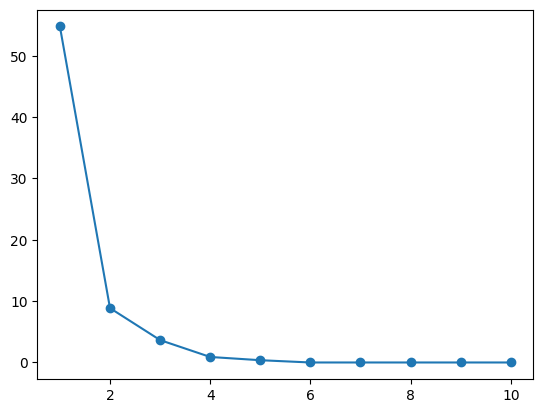

In [14]:
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_transformed)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')